## Installing Libraries

In [ ]:
#!pip install tensorflow tensorflow_datasets
#!pip install scikit-learn seaborn matplotlib

## Importing Libraries

In [ ]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as F
from torchvision.models import EfficientNet_V2_S_Weights
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from PIL import Image
import json
import urllib.request



## Extracting Folder

In [ ]:
# Path of zip folder
zip_path = '/content/data.zip'

# Destination path
extract_dir = '/content/my_dataset'

# Create destination if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracting complete. Saved to '{extract_dir}'")


Extracting complete. Saved to '/content/my_dataset'


## Configuration

In [ ]:
# ==========================================
# 1. CONFIGURATION
# ==========================================

DATASET_PATH = '/content/my_dataset/data' # dataset address
BATCH_SIZE = 32
EPOCHS = 10                    # Adjust based on your needs
LEARNING_RATE = 1e-4           # Lower LR for fine-tuning
N_FOLDS = 5
TEST_SPLIT_SIZE = 0.2          # 20% held out for final testing
SEED = 42

# EfficientNet V2 S specific requirements
IMG_SIZE = 384
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Resize Image Function

In [ ]:
"""
class SquarePad:
    def __init__(self, size, fill=255, padding_mode='constant'):

        #Args:
            #size (int): The strict height and width of the output square (e.g., 224).
            #fill (int): Pixel fill value. 255 is white.

        self.size = size
        self.fill = fill
        self.padding_mode = padding_mode

    def __call__(self, img):
        # 1. Get dimensions
        w, h = F.get_image_size(img)

        # 2. Calculate Scale to fit the largest side into the square
        max_dim = max(w, h)
        scale = self.size / max_dim

        new_w = int(w * scale)
        new_h = int(h * scale)

        # 3. Resize
        img = F.resize(img, (new_h, new_w))

        # 4. Calculate Padding to reach 1:1 ratio
        # One of these will be 0, the other will be the padding amount
        diff_w = self.size - new_w
        diff_h = self.size - new_h

        pad_left = diff_w // 2
        pad_top = diff_h // 2
        pad_right = diff_w - pad_left
        pad_bottom = diff_h - pad_top

        # 5. Apply Padding (Left, Top, Right, Bottom)
        padding = (pad_left, pad_top, pad_right, pad_bottom)
        return F.pad(img, padding, self.fill, self.padding_mode)

  """


  #Usage:
  #Replace
  #transforms.Resize((IMG_SIZE, IMG_SIZE))
  #With
  #SquarePad(size=IMG_SIZE, fill=255)


## Transforms & Dataset

In [ ]:
# ==========================================
# 2. TRANSFORMS & DATASET
# ==========================================

# A. Heavy Augmentation (For Training Only)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
    ], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

# B. Clean Transform (For Validation & Test)
clean_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

# Load Data References
# We load twice: one for augmenting, one for clean validation
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset path '{DATASET_PATH}' not found.")

dataset_aug = datasets.ImageFolder(root=DATASET_PATH, transform=train_transform)
dataset_clean = datasets.ImageFolder(root=DATASET_PATH, transform=clean_transform)

class_names = dataset_clean.classes
num_classes = len(class_names)
print(f"Classes found: {class_names}")

FileNotFoundError: Dataset path '/content/my_dataset/data' not found.

## Helper Functions

In [ ]:
# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================

def get_fresh_model(num_classes):
    """Initializes a fresh EfficientNet_V2_S model."""
    weights = EfficientNet_V2_S_Weights.DEFAULT
    model = models.efficientnet_v2_s(weights=weights)

    # Modify the classifier head
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model.to(device)

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

def validate_one_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

## Train-Test Split

In [ ]:
# Get all targets for stratification
all_targets = np.array(dataset_aug.targets)
all_indices = np.arange(len(all_targets))

# Split indices
train_val_idx, test_idx, train_val_labels, test_labels = train_test_split(
    all_indices,
    all_targets,
    test_size=TEST_SPLIT_SIZE,
    stratify=all_targets,
    random_state=SEED
)

# Create the permanent Test Loader (always uses clean images)
test_subset = Subset(dataset_clean, test_idx)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total Images: {len(all_indices)}")
print(f"Held-out Test Set: {len(test_idx)}")
print(f"Remaining for CV: {len(train_val_idx)}")

Total Images: 113
Held-out Test Set: 23
Remaining for CV: 90


## Cross-Validation Training Loop

In [ ]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

fold_best_accs = []

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

for fold, (inner_train_idx, inner_val_idx) in enumerate(skf.split(train_val_idx, train_val_labels)):
    print(f"\n================ FOLD {fold + 1}/{N_FOLDS} ================")

    # 1. Map indices back to global dataset
    actual_train_idx = train_val_idx[inner_train_idx]
    actual_val_idx = train_val_idx[inner_val_idx]

    # 2. Create Loaders (Train=Augmented, Val=Clean)
    train_subset = Subset(dataset_aug, actual_train_idx)
    val_subset = Subset(dataset_clean, actual_val_idx)

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    # 3. Initialize Model
    model = get_fresh_model(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    best_acc = 0.0
    best_weights = copy.deepcopy(model.state_dict())

    # 4. Training Loop
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion)

        scheduler.step(val_loss)

        print(f"  Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Save best weights
        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

    # 5. Save Model to Disk
    save_path = f'efficientnet_fold_{fold+1}_best.pth'
    torch.save(best_weights, save_path)
    fold_best_accs.append(best_acc)
    print(f"  -> Fold {fold+1} Best Acc: {best_acc:.4f} (Saved)")

print(f"\nAverage Validation Accuracy: {np.mean(fold_best_accs)*100:.2f}%")

Starting 5-Fold Cross Validation...

================ FOLD 1/5 ================
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:01<00:00, 56.8MB/s]


  Epoch 1 | Train Acc: 0.2639 | Val Loss: 1.7955 | Val Acc: 0.3333
  Epoch 2 | Train Acc: 0.4583 | Val Loss: 1.7380 | Val Acc: 0.6111
  Epoch 3 | Train Acc: 0.6389 | Val Loss: 1.6495 | Val Acc: 0.7222
  Epoch 4 | Train Acc: 0.7500 | Val Loss: 1.5200 | Val Acc: 0.8889
  Epoch 5 | Train Acc: 0.9028 | Val Loss: 1.3616 | Val Acc: 0.9444
  Epoch 6 | Train Acc: 0.8750 | Val Loss: 1.1593 | Val Acc: 0.9444
  Epoch 7 | Train Acc: 0.8889 | Val Loss: 0.9469 | Val Acc: 0.9444
  Epoch 8 | Train Acc: 0.9722 | Val Loss: 0.7639 | Val Acc: 0.9444
  Epoch 9 | Train Acc: 0.9722 | Val Loss: 0.6343 | Val Acc: 1.0000
  Epoch 10 | Train Acc: 1.0000 | Val Loss: 0.5241 | Val Acc: 1.0000
  -> Fold 1 Best Acc: 1.0000 (Saved)

================ FOLD 2/5 ================
  Epoch 1 | Train Acc: 0.0833 | Val Loss: 1.9565 | Val Acc: 0.1667
  Epoch 2 | Train Acc: 0.3750 | Val Loss: 1.8811 | Val Acc: 0.3889
  Epoch 3 | Train Acc: 0.6944 | Val Loss: 1.7715 | Val Acc: 0.6667
  Epoch 4 | Train Acc: 0.8194 | Val Loss: 1.625

## Test Loop for Saved Models


================ ENSEMBLE TESTING ================
Final Test Accuracy: 100.00%

Classification Report:
                   precision    recall  f1-score   support

adjustable_wrench       1.00      1.00      1.00         3
       box_cutter       1.00      1.00      1.00         3
       breadboard       1.00      1.00      1.00         1
  long_nose_plier       1.00      1.00      1.00         3
       multimeter       1.00      1.00      1.00         2
      screwdriver       1.00      1.00      1.00         5
     tape_measure       1.00      1.00      1.00         6

         accuracy                           1.00        23
        macro avg       1.00      1.00      1.00        23
     weighted avg       1.00      1.00      1.00        23



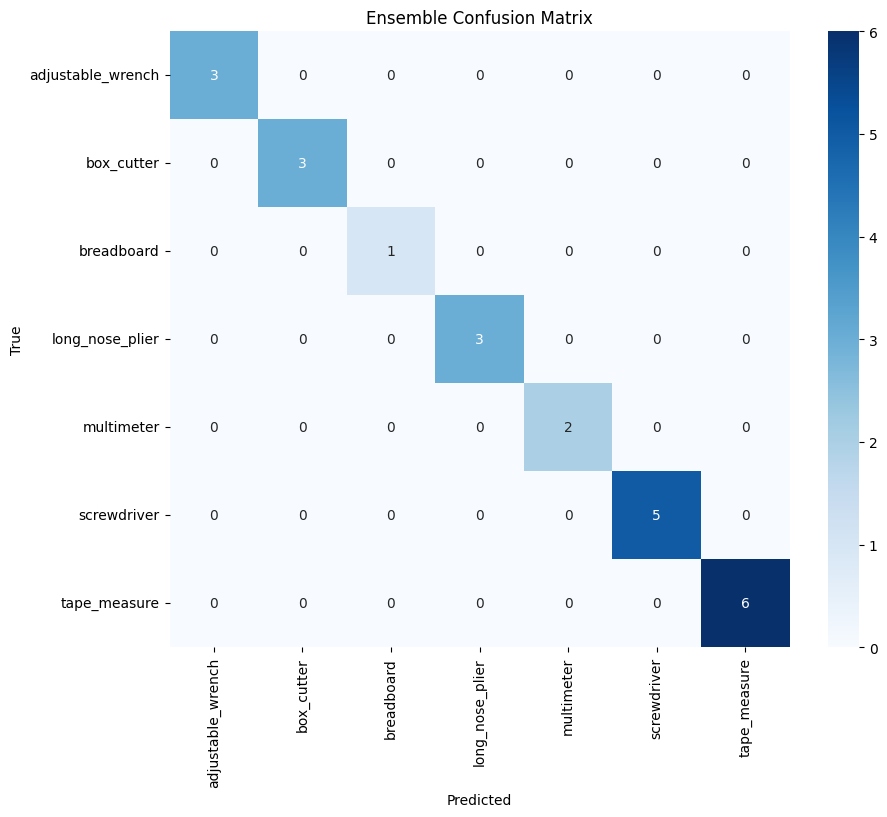

In [ ]:
print("\n================ ENSEMBLE TESTING ================")
models_list = []

# 1. Load all saved models
for i in range(N_FOLDS):
    m = get_fresh_model(num_classes)
    path = f'efficientnet_fold_{i+1}_best.pth'
    m.load_state_dict(torch.load(path, map_location=device))
    m.eval()
    models_list.append(m)

y_true = []
y_pred = []

# 2. Run Inference
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_true.extend(labels.cpu().numpy())

        # Accumulate Probabilities
        avg_probs = torch.zeros(images.size(0), num_classes).to(device)
        for m in models_list:
            outputs = m(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            avg_probs += probs

        # Average and pick winner
        avg_probs /= len(models_list)
        _, predicted = torch.max(avg_probs, 1)
        y_pred.extend(predicted.cpu().numpy())

# 3. Visualize Results
print(f"Final Test Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Confusion Matrix')
plt.show()

## Train New Model with Full Dataset

In [ ]:
# ==========================================
# 1. CONFIGURATION (Use your best findings here)
# ==========================================
BATCH_SIZE = 16
LEARNING_RATE = 1e-4  # Use the LR that worked best in CV
EPOCHS = 10           # Use the average stopping epoch from CV (e.g., if it stopped at 8, put 8)
SAVE_NAME = 'efficientnet_production_v1.pth'


# Load the entire folder as one dataset
full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=train_transform)
train_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Training on 100% of data: {len(full_dataset)} images")
print(f"Classes: {full_dataset.classes}")

# ==========================================
# 3. INITIALIZE MODEL
# ==========================================
print("Initializing fresh model...")
weights = EfficientNet_V2_S_Weights.DEFAULT
model = models.efficientnet_v2_s(weights=weights)

# Custom Head
num_classes = len(full_dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.to(device)

# Tools
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ==========================================
# 4. TRAINING LOOP (Blind)
# ==========================================
# Note: We do NOT have a validation loop here because we are using all data for training.
# We rely on the fact that CV already proved this architecture works.

print("Starting Production Training...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

# ==========================================
# 5. SAVE FINAL MODEL
# ==========================================
torch.save(model.state_dict(), SAVE_NAME)
print(f"\n✅ DONE! Final production model saved to: {SAVE_NAME}")
print("This model has seen every image you have and is ready for deployment.")

Training on 100% of data: 113 images
Classes: ['adjustable_wrench', 'box_cutter', 'breadboard', 'long_nose_plier', 'multimeter', 'screwdriver', 'tape_measure']
Initializing fresh model...
Starting Production Training...
Epoch 1/10 | Loss: 1.8461 | Accuracy: 0.3451
Epoch 2/10 | Loss: 1.5873 | Accuracy: 0.6637
Epoch 3/10 | Loss: 1.2796 | Accuracy: 0.7876
Epoch 4/10 | Loss: 0.8952 | Accuracy: 0.9381
Epoch 5/10 | Loss: 0.5976 | Accuracy: 0.9735
Epoch 6/10 | Loss: 0.3635 | Accuracy: 0.9823
Epoch 7/10 | Loss: 0.2189 | Accuracy: 0.9735
Epoch 8/10 | Loss: 0.1398 | Accuracy: 0.9912
Epoch 9/10 | Loss: 0.0981 | Accuracy: 0.9912
Epoch 10/10 | Loss: 0.0752 | Accuracy: 1.0000

✅ DONE! Final production model saved to: efficientnet_production_v1.pth
This model has seen every image you have and is ready for deployment.


## Fine Tuning

In [ ]:
# --- Configuration ---
BEST_MODEL_PATH = 'efficientnet_production_v1.pth' # Point to your best fold
NEW_BATCH_SIZE = 16    # Lower batch size slightly to save memory if needed
NEW_EPOCHS = 4
NEW_LR = 1e-6      # Very slow learning rate


# --- 1. Load Data (Training on EVERYTHING except Test Set) ---
# We use the 'Augmented' transform because we are still training

new_train_loader = DataLoader(dataset_aug, batch_size=NEW_BATCH_SIZE, shuffle=True)

# --- 2. Load the Pre-Trained Model ---
print(f"Loading weights from {BEST_MODEL_PATH}...")
weights = EfficientNet_V2_S_Weights.DEFAULT
model = models.efficientnet_v2_s(weights=weights)

# Rebuild Head
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Load State
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.to(device)


# --- 3. The Setup for Fine-Tuning ---
criterion = nn.CrossEntropyLoss()

# IMPORTANT: We use a much smaller learning rate
optimizer = optim.Adam(model.parameters(), lr=NEW_LR)

# --- 4. Training Loop ---
print("Starting Fine-Tuning...")
model.train()

for epoch in range(NEW_EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in new_train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{NEW_EPOCHS} | Loss: {running_loss/total:.4f} | Acc: {epoch_acc:.4f}")

# Save the refined model
torch.save(model.state_dict(), 'efficientnet_finetuned.pth')
print("Fine-tuning complete. Saved to efficientnet_finetuned.pth")

Loading weights from efficientnet_production_v1.pth...
Starting Fine-Tuning...
Epoch 1/4 | Loss: 0.0962 | Acc: 0.9823
Epoch 2/4 | Loss: 0.0471 | Acc: 1.0000
Epoch 3/4 | Loss: 0.0679 | Acc: 1.0000
Epoch 4/4 | Loss: 0.1010 | Acc: 0.9646
Fine-tuning complete. Saved to efficientnet_finetuned.pth


## Test Trained Model with an Image

In [ ]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
IMAGE_PATH = 'test_image.jpg'        # The image you want to classify
MODEL_PATH = 'efficientnet_finetuned.pth' # Path to one of your saved models

# IMPORTANT: These must match the folder names in your dataset EXACTLY,
# and be in alphabetical order (0, 1, 2...).
CLASS_NAMES = ['adjustable_wrench', 'box_cutter', 'breadboard', 'long_nose_plier', 'multimeter', 'screwdriver', 'tape_measure']
#CLASS_NAMES = ['adjustable_wrench', 'box_cutter']

# EfficientNet V2 S Stats
IMG_SIZE = 384
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# ==========================================
# 2. SETUP
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Transform (Same as the "Clean" validation transform)
inference_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

def load_model(path, num_classes):
    print("Building model architecture...")
    # 1. Load the base architecture
    weights = EfficientNet_V2_S_Weights.DEFAULT
    model = models.efficientnet_v2_s(weights=weights)

    # 2. Re-create the modified head (Vital step!)
    # The saved file only has numbers (weights), not the structure.
    # We must rebuild the structure exactly as it was during training.
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    # 3. Load the weights
    print(f"Loading weights from {path}...")
    # map_location ensures this runs even if you trained on GPU but test on CPU
    model.load_state_dict(torch.load(path, map_location=device))

    model.to(device)
    model.eval() # Set to evaluation mode (Freezes Dropout/Batch Norm)
    return model

# ==========================================
# 3. RUN PREDICTION
# ==========================================
if __name__ == '__main__':
    try:
        # 1. Load Model
        model = load_model(MODEL_PATH, len(CLASS_NAMES))

        # 2. Load and Preprocess Image
        image = Image.open(IMAGE_PATH).convert('RGB') # Ensure it's RGB
        input_tensor = inference_transform(image)

        # Add batch dimension (Model expects [1, 3, 384, 384], not [3, 384, 384])
        input_batch = input_tensor.unsqueeze(0).to(device)

        # 3. Predict
        with torch.no_grad():
            output = model(input_batch)

            # Convert raw output to probabilities
            probabilities = torch.nn.functional.softmax(output[0], dim=0)

            # Get top prediction
            top_prob, top_catid = torch.topk(probabilities, 1)

            # Map ID to Name
            class_id = top_catid.item()
            score = top_prob.item()
            class_name = CLASS_NAMES[class_id]

            print(f"\n-----------------------------")
            print(f"Prediction: {class_name.upper()}")
            print(f"Confidence: {score*100:.2f}%")
            print(f"-----------------------------")

            # Optional: Print all probabilities
            for i, prob in enumerate(probabilities):
                print(f"{CLASS_NAMES[i]}: {prob.item()*100:.2f}%")

    except FileNotFoundError:
        print(f"Error: File not found. Check {IMAGE_PATH} or {MODEL_PATH}")
    except Exception as e:
        print(f"An error occurred: {e}")

Building model architecture...
Loading weights from efficientnet_finetuned.pth...

-----------------------------
Prediction: BOX_CUTTER
Confidence: 94.23%
-----------------------------
adjustable_wrench: 1.89%
box_cutter: 94.23%
breadboard: 0.97%
long_nose_plier: 0.77%
multimeter: 1.00%
screwdriver: 0.67%
tape_measure: 0.46%
